In [1]:
import pandas as pd
from collections import Counter
import seaborn as sns
import umap
import matplotlib.pyplot as plt
import texthero as hero
import polarice
import polarice.preprocessing
from gensim.models import KeyedVectors
import glob
import numpy as np

np.random.seed(42)

data_dir = "./data/framing/elites_tweets/"
limit_top_w2v = 500_000

In [2]:
all_files = glob.glob(data_dir + "*.jsonl")

li = []

for filename in all_files:
    df = pd.read_json(filename, lines=True)
    li.append(df)

frame = pd.concat(li, axis=0, ignore_index=True)

In [3]:
elites_df = pd.read_csv(data_dir + "../input/elites-data.csv")
elites_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 587 entries, 0 to 586
Data columns (total 10 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   thomas_id     547 non-null    float64
 1   id            547 non-null    object 
 2   chamber       547 non-null    object 
 3   stdis         547 non-null    object 
 4   first_name    547 non-null    object 
 5   last_name     547 non-null    object 
 6   party         587 non-null    object 
 7   twitter_name  556 non-null    object 
 8   twitter_id    556 non-null    float64
 9   type          587 non-null    object 
dtypes: float64(2), object(8)
memory usage: 46.0+ KB


In [4]:
frame["user_id"] = frame["user"].map(lambda x: x["id"])
frame.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1439000 entries, 0 to 1438999
Data columns (total 35 columns):
 #   Column                     Non-Null Count    Dtype              
---  ------                     --------------    -----              
 0   created_at                 1439000 non-null  datetime64[ns, UTC]
 1   id                         1439000 non-null  int64              
 2   id_str                     1439000 non-null  int64              
 3   full_text                  1439000 non-null  object             
 4   truncated                  1439000 non-null  bool               
 5   display_text_range         1439000 non-null  object             
 6   entities                   1439000 non-null  object             
 7   source                     1439000 non-null  object             
 8   in_reply_to_status_id      124710 non-null   float64            
 9   in_reply_to_status_id_str  124710 non-null   float64            
 10  in_reply_to_user_id        132186 non-null

In [5]:
frame["user_id"].nunique()

511

In [6]:
labelled_tweets = frame.merge(elites_df, left_on="user_id", right_on="twitter_id")

In [ ]:
german_tweet_pipeline = polarice.preprocessing.ENGLISH_TWEET_PIPELINE
labelled_tweets["cleaned"] = labelled_tweets["full_text"].pipe(hero.clean, pipeline=german_tweet_pipeline)
labelled_tweets  # output clear for privacy

In [8]:
model = KeyedVectors.load_word2vec_format("glove.840B.300d_w2v.txt", binary=False, limit=limit_top_w2v)

In [9]:
%run frame_axis.py

fs = FrameSystem.load("moral.pkl")
fs.attach_model(model)
fs.compute()
fs.frame_axes

{'care/harm': <__main__.FrameAxis at 0x7f953d316b50>,
 'fairness/cheating': <__main__.FrameAxis at 0x7f953d7720d0>,
 'loyalty/betrayal': <__main__.FrameAxis at 0x7f955810f3d0>,
 'authority/subversion': <__main__.FrameAxis at 0x7f955a3e2820>,
 'sanctity/degradation': <__main__.FrameAxis at 0x7f9559584f10>}

In [10]:
%%time
fs.axes_ordered_by_effect_sizes(labelled_tweets["cleaned"], num_bootstrap_samples=1)

100%|██████████| 1/1 [08:18<00:00, 498.88s/it]

CPU times: user 1h 20min 57s, sys: 1min 37s, total: 1h 22min 34s
Wall time: 1h 22min 35s


OrderedDict([('loyalty/betrayal',
              EffectSize(eta_bias=1.4827861161137434e-12, eta_intensity=2.832439144340171e-13)),
             ('fairness/cheating',
              EffectSize(eta_bias=9.26939081047351e-13, eta_intensity=2.946254351599009e-14)),
             ('care/harm',
              EffectSize(eta_bias=5.456052276642254e-13, eta_intensity=1.1034055613645677e-13)),
             ('authority/subversion',
              EffectSize(eta_bias=3.381184221495914e-13, eta_intensity=7.972095206199015e-14)),
             ('sanctity/degradation',
              EffectSize(eta_bias=2.278802146982173e-13, eta_intensity=6.956327874840795e-14))])

In [ ]:
%%time
trans_df = fs.transform_df(labelled_tweets, "cleaned", model)
trans_df  # output clear for privacy

In [14]:
bias_cols = [col for col in labelled_tweets if col.endswith("_bias")]
intensity_cols = [col for col in labelled_tweets if col.endswith("_inte")]
moral_cols = bias_cols + intensity_cols

In [15]:
cm = sns.light_palette("green", as_cmap=True)

groups = labelled_tweets.groupby("party")[moral_cols]
group_moral = groups.mean()

In [16]:
latex_df = group_moral.transpose()
latex_df.index = pd.MultiIndex.from_tuples(latex_df.index.str.split('_').tolist())
latex_df = latex_df.swaplevel(0, 1, 0)
latex_df = latex_df.rename(index={
    "care": "Care",
    "fair": "Fairness",
    "loya": "Loyalty",
    "auth": "Authority",
    "sanc": "Sanctity",
    "bias": "Bias",
    "intensity": "Intensity"
})
latex_df = latex_df * 10  # for easier readability
print(latex_df.to_latex(multirow=True, float_format="%.3f"))

\begin{tabular}{llrrrr}
\toprule
     & party &     D &     I &     N &     R \\
\midrule
\multirow{5}{*}{Bias} & Care & 0.797 & 0.788 & 0.550 & 0.820 \\
     & Fairness & 1.027 & 1.039 & 0.827 & 1.018 \\
     & Loyalty & 1.348 & 1.415 & 1.108 & 1.338 \\
     & Authority & 1.326 & 1.360 & 1.076 & 1.334 \\
     & Sanctity & 0.600 & 0.571 & 0.463 & 0.626 \\
\cline{1-6}
\multirow{5}{*}{inte} & Care & 0.135 & 0.140 & 0.128 & 0.129 \\
     & Fairness & 0.092 & 0.097 & 0.098 & 0.088 \\
     & Loyalty & 0.130 & 0.131 & 0.133 & 0.128 \\
     & Authority & 0.125 & 0.125 & 0.140 & 0.121 \\
     & Sanctity & 0.069 & 0.072 & 0.070 & 0.070 \\
\bottomrule
\end{tabular}



In [17]:
latex_df.style.background_gradient(cmap=cm, axis=1)

# Classification

In [18]:
y_label = "party"

In [19]:
bias_cols = [col for col in labelled_tweets if col.endswith("_bias")]
intensity_cols = [col for col in labelled_tweets if col.endswith("_inte")]
moral_cols = bias_cols + intensity_cols

In [20]:
Y = labelled_tweets[y_label].values
X = labelled_tweets[moral_cols].values
print(X.shape)
print(np.expand_dims(Y, axis=1).shape)
np.concatenate([X, np.expand_dims(Y, axis=1)], axis=1)

(1439000, 10)
(1439000, 1)


array([[0.14281115531921387, 0.08430562019348145, 0.130345356464386, ...,
        0.007425813376903534, 0.019551602005958558, 'R'],
       [0.09149552881717682, 0.11361437290906906, 0.14533887803554535,
        ..., 0.011606198735535145, 0.009537599049508572, 'R'],
       [0.08008612337566558, 0.048064867655436196, 0.11717059498741514,
        ..., 0.007243632560684567, 0.004354695833864666, 'R'],
       ...,
       [0.09520983695983887, 0.1262257628970676, 0.1461369726392958, ...,
        0.0028629211915863883, 0.009111358059777154, 'N'],
       [0.07717092335224152, 0.07945317775011063, 0.08746727555990219,
        ..., 0.019387369975447655, 0.01059896033257246, 'N'],
       [0.02272539585828781, -0.009635661418239275, 0.0333074281613032,
        ..., 0.05065882205963135, 0.0167401023209095, 'N']], dtype=object)

In [21]:
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.25, shuffle=True)
classifier = LogisticRegression(max_iter=1000).fit(X_train, Y_train)
    
Y_pred = classifier.predict(X_test)
classification_report(Y_test, Y_pred, output_dict=True)

/home/mreiterhaas/miniconda3/envs/polarice/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


{'D': {'precision': 0.5183841706918191,
  'recall': 0.6193919632814896,
  'f1-score': 0.5644045074096887,
  'support': 176042},
 'I': {'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 1606},
 'N': {'precision': 0.2857142857142857,
  'recall': 0.00017678776628657296,
  'f1-score': 0.000353356890459364,
  'support': 11313},
 'R': {'precision': 0.5188789750935414,
  'recall': 0.45389340062884614,
  'f1-score': 0.48421552338001417,
  'support': 170789},
 'accuracy': 0.5185851285615011,
 'macro avg': {'precision': 0.3307443578749115,
  'recall': 0.2683655379191556,
  'f1-score': 0.2622433469200406,
  'support': 359750},
 'weighted avg': {'precision': 0.5089881672507734,
  'recall': 0.5185851285615011,
  'f1-score': 0.5060780565461221,
  'support': 359750}}

In [22]:
print(classification_report(Y_test, Y_pred))

              precision    recall  f1-score   support

           D       0.52      0.62      0.56    176042
           I       0.00      0.00      0.00      1606
           N       0.29      0.00      0.00     11313
           R       0.52      0.45      0.48    170789

    accuracy                           0.52    359750
   macro avg       0.33      0.27      0.26    359750
weighted avg       0.51      0.52      0.51    359750



In [23]:
classifier.coef_

array([[  2.50547372,   2.13025162,  -1.41860336,  -0.38525283,
          0.47588155,   9.70061958,   4.3764928 ,   0.16605908,
         -3.45261164,  -2.96672476],
       [ -3.12643055,  -0.38925235,   5.48425757,   1.88795337,
         -1.13351253,   3.59891956,   2.23980598,   1.33972484,
          1.46967455,   1.56627523],
       [ -3.17026594,  -2.8563516 ,   1.20310499,  -3.84529816,
         -1.44435412, -12.66386288,   1.53746855, -11.46213757,
          8.31207326,  -1.86050521],
       [  3.79122277,   1.11535233,  -5.26875921,   2.34259763,
          2.1019851 ,  -0.63567627,  -8.15376734,   9.95635365,
         -6.32913617,   3.26095474]])

In [46]:
coef_df = pd.DataFrame.from_records(classifier.coef_, index=classifier.classes_, columns=moral_cols)
print(coef_df.to_latex())
coef_df

\begin{tabular}{lrrrrrrrrrr}
\toprule
{} &  care\_bias &  fair\_bias &  loya\_bias &  auth\_bias &  sanc\_bias &  care\_inte &  fair\_inte &  loya\_inte &  auth\_inte &  sanc\_inte \\
\midrule
D &   2.505474 &   2.130252 &  -1.418603 &  -0.385253 &   0.475882 &   9.700620 &   4.376493 &   0.166059 &  -3.452612 &  -2.966725 \\
I &  -3.126431 &  -0.389252 &   5.484258 &   1.887953 &  -1.133513 &   3.598920 &   2.239806 &   1.339725 &   1.469675 &   1.566275 \\
N &  -3.170266 &  -2.856352 &   1.203105 &  -3.845298 &  -1.444354 & -12.663863 &   1.537469 & -11.462138 &   8.312073 &  -1.860505 \\
R &   3.791223 &   1.115352 &  -5.268759 &   2.342598 &   2.101985 &  -0.635676 &  -8.153767 &   9.956354 &  -6.329136 &   3.260955 \\
\bottomrule
\end{tabular}



,care_bias,fair_bias,loya_bias,auth_bias,sanc_bias,care_inte,fair_inte,loya_inte,auth_inte,sanc_inte
D,2.505474,2.130252,-1.418603,-0.385253,0.475882,9.700620,4.376493,0.166059,-3.452612,-2.966725
I,-3.126431,-0.389252,5.484258,1.887953,-1.133513,3.598920,2.239806,1.339725,1.469675,1.566275
N,-3.170266,-2.856352,1.203105,-3.845298,-1.444354,-12.663863,1.537469,-11.462138,8.312073,-1.860505
R,3.791223,1.115352,-5.268759,2.342598,2.101985,-0.635676,-8.153767,9.956354,-6.329136,3.260955


In [24]:
coef_df = coef_df.stack().to_frame().reset_index()
coef_df[["moral", "bias/inte"]] = coef_df["level_1"].str.split("_", expand=True)
coef_df = coef_df.drop(columns=["level_1"])
coef_df = coef_df.rename(columns={"level_0": "handle", 0: "coef"})
coef_df

,handle,coef,moral,bias/inte
0,D,2.505474,care,bias
1,D,2.130252,fair,bias
2,D,-1.418603,loya,bias
3,D,-0.385253,auth,bias
4,D,0.475882,sanc,bias
5,D,9.700620,care,inte
6,D,4.376493,fair,inte
7,D,0.166059,loya,inte
8,D,-3.452612,auth,inte
9,D,-2.966725,sanc,inte


<AxesSubplot:xlabel='moral', ylabel='coef'>

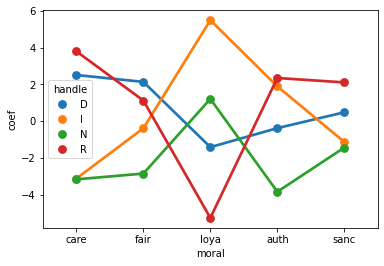

In [25]:
bias_df = coef_df[coef_df["bias/inte"] == "bias"]
sns.pointplot(data=bias_df, x="moral", y="coef", hue="handle")

<AxesSubplot:xlabel='moral', ylabel='coef'>

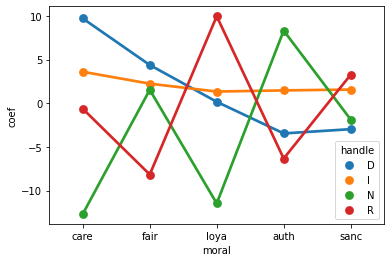

In [26]:
inte_df = coef_df[coef_df["bias/inte"] == "inte"]
sns.pointplot(data=inte_df, x="moral", y="coef", hue="handle")

In [ ]:
# pairplot on traindata: https://scikit-learn.org/stable/auto_examples/inspection/plot_linear_model_coefficient_interpretation.html
dataset = labelled_tweets[[y_label] + moral_cols].copy()
dataset  # output clear for privacy

In [43]:
ds = dataset.sample(10_000)

In [ ]:
%%time
g = sns.pairplot(ds, kind="reg", diag_kind="kde", hue="party")
g.map_lower(sns.kdeplot, levels=4, color=".2")
plt.savefig("pairplot_us.pdf", dpi=300)
plt.show()